# Pixeltable <> VideoDB 
<a href="https://colab.research.google.com/github/video-db/videodb-cookbook/blob/main/docs/integrations/pixeltable/scene_index_experimentation_pxt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from videodb.timeline import Timeline
from videodb.asset import VideoAsset, TextAsset 
from videodb import TextStyle 


In [12]:
OBJ_MAPPINGS = {}

In [13]:
import pixeltable as pxt

def get_dynamic_position(percent, vertical=True):
    total = "w"
    text = "tw"
    if vertical:
        total = "h"
        text = "th"
    return f"({total} - {text})/{100/percent}"


@pxt.udf
def geneate_scene_preview(a: float, b: float, id: str, description: str) -> str:
    total_duration = b - a
    table_obj = OBJ_MAPPINGS[id]

    timeline = Timeline(table_obj.conn)
    video_asset = VideoAsset(asset_id=table_obj.video.id, start=a, end=b)

    common_config = {"font": "Do Hyeon", "alpha": 0.5}
    overlay_assets = []

    # -- Scene Start and end
    asset = TextAsset(
        text=f"Scene start\: {a}",
        duration=total_duration,
        style=TextStyle(
            y=get_dynamic_position(10),
            x=get_dynamic_position(5, vertical=True),
            **common_config,
        ),
    )
    overlay_assets.append(asset)

    asset = TextAsset(
        text=f"Scene end\: {b}",
        duration=total_duration,
        style=TextStyle(
            y=get_dynamic_position(20),
            x=get_dynamic_position(5, vertical=True),
            **common_config,
        ),
    )
    overlay_assets.append(asset)

    # -- Extraction type info
    asset = TextAsset(
        text=f"Type\ {table_obj.scenes_config['extraction_type']}",
        duration=total_duration,
        style=TextStyle(
            y=get_dynamic_position(40),
            x=get_dynamic_position(5, vertical=True),
            **common_config,
        ),
    )
    overlay_assets.append(asset)

    asset = TextAsset(
        text="Config",
        duration=total_duration,
        style=TextStyle(
            y=get_dynamic_position(50),
            x=get_dynamic_position(5, vertical=True),
            **common_config,
        ),
    )
    overlay_assets.append(asset)

    # ignore extraction_type
    configs = list(table_obj.scenes_config.items())[1:]
    for key_index, (key, value) in enumerate(configs):
        asset = TextAsset(
            text=f"{key} \: {value}",
            duration=total_duration,
            style=TextStyle(
                y=get_dynamic_position(60 + key_index * 10),
                x=get_dynamic_position(10, vertical=True),
                **common_config,
            ),
        )
        overlay_assets.append(asset)

    asset = TextAsset(
        text="Description",
        duration=total_duration,
        style=TextStyle(
            y=get_dynamic_position(10),
            x=get_dynamic_position(50, vertical=False),
            **common_config,
        ),
    )
    overlay_assets.append(asset)

    asset = TextAsset(
        text=f"{description}",
        duration=total_duration,
        style=TextStyle(
            y=get_dynamic_position(20),
            x=get_dynamic_position(50, vertical=False),
            **common_config,
        ),
    )
    overlay_assets.append(asset)

    timeline.add_inline(video_asset)
    for asset in overlay_assets:
        timeline.add_overlay(start=0, asset=asset)

    stream_url = timeline.generate_stream()
    stream_url = f"https://console.videodb.io/player?url={stream_url}"
    return f"{stream_url}"


@pxt.udf
def describe_scene(a: float, b: float, id: str, prompt: str) -> str:
    table_obj = OBJ_MAPPINGS[id]
    target_scene = None

    for scene in table_obj.scenes:
        if scene.start == a and scene.end == b:
            target_scene = scene

    if target_scene is None:
        return "Error: Scene not extracted"
    else:
        res = target_scene.describe(prompt)
        return res

In [14]:
class ExperimentTable:
    def __init__(self, conn, coll_id, video_id, scn_coll_id, table_dir, table_name):
        self.conn = conn
        self.coll = self.conn.get_collection(coll_id)
        self.video = self.coll.get_video(video_id)
        self.scene_coll = self.video.get_scene_collection(scn_coll_id)
        self.scenes_config = self.scene_coll.config
        self.scenes = self.scene_coll.scenes
        self.table_dir = table_dir
        self.table_name = table_name
        self.table = self.create_px_table()
        OBJ_MAPPINGS[scn_coll_id] = self
    
    def create_px_table(self):
        pxt.create_dir(self.table_dir, ignore_errors=True)
        table_name = f"{self.table_dir}.{self.table_name}"
        pxt.drop_table(table_name, ignore_errors=True)

        frames_schemas = {}
        # Dont just look at first scene, instead look at all frames and find max.
        no_frames = len(self.scenes[0].frames)
        for i in range(1, no_frames+1):
            frames_schemas[f"frame_{i}"] = pxt.ImageType()

        t = pxt.create_table(
            table_name,
            {"start": pxt.FloatType(), "end": pxt.FloatType(), **frames_schemas},
        )

        # Should/Can this be decoupled ?
        for scene in self.scenes:
            frames = {}
            for num, frame in enumerate(scene.frames):
                frame_id = f'frame_{num+1}'
                frames[frame_id] = frame.url
            t.insert(start=scene.start, end=scene.end, **frames)

        return t
    
    def add_stream_preview(self, col_name, description_col):
        self.table[col_name] = geneate_scene_preview(self.table.start, self.table.end, self.scene_coll.id, description_col)
    
    def add_scene_description(self, col_name, prompt=""):
        self.table[col_name] = describe_scene(self.table.start, self.table.end, self.scene_coll.id, prompt) 


In [15]:
from videodb import connect
import os

os.environ["VIDEO_DB_API_KEY"] = ""

conn = connect()
coll = conn.get_collection()
coll_id = coll.id

In [16]:
video = coll.get_video("YOUR_ID_HERE")

In [17]:
scene_cols = video.list_scene_collection()
for scene_col in scene_cols:
    print(scene_col)
    # video.delete_scene_collection(scene_col["scene_collection_id"])

{'config': {'extraction_type': 'shot', 'frame_count': '3', 'threshold': '20'}, 'scene_collection_id': 'st20m15f3', 'status': 'done'}
{'config': {'extraction_type': 'time', 'select_frames': ['first'], 'time': '10'}, 'scene_collection_id': 'tt10sf', 'status': 'done'}


In [8]:
indexes = video.list_scene_index()
for index in indexes:
    print(index)
    # video.delete_scene_index(index["scene_index_id"])

{'name': 'Scene Index 2024-07-08 11:28', 'scene_index_id': '86d12764b9e28618', 'status': 'done'}


In [ ]:
### Direct
from videodb import SceneExtractionType

_scenes_time = video.extract_scenes(extraction_type=SceneExtractionType.time_based)
_scenes_shot = video.extract_scenes(extraction_type=SceneExtractionType.shot_based, extraction_config={"frame_count": 3})

In [18]:
scenes_time = video.get_scene_collection(_scenes_time.id)
scenes_shot = video.get_scene_collection(_scenes_shot.id)
# scenes_time = video.get_scene_collection("tt10sf")
# scenes_shot = video.get_scene_collection("st20m15f3")

print(scenes_time.scenes[0].frames[0].url)
print(scenes_shot.scenes[0].frames[0].url)

https://storage.googleapis.com/videodb-dev.appspot.com/media/u-cc36fd41-567b-4ab5-8b05-d215437275f3/m-153773da-eed4-4e49-be1e-cde94d8258aa/frames/frm-scn-tt10sf-0.0-10.01-0.0/img-50ff4c6c-d172-4bbb-8a06-63b4e21b6bd2.png
https://storage.googleapis.com/videodb-dev.appspot.com/media/u-cc36fd41-567b-4ab5-8b05-d215437275f3/m-153773da-eed4-4e49-be1e-cde94d8258aa/frames/frm-scn-st20m15f3-0.0-1.043-0.0/img-d65b58cb-5419-471d-852b-479e83bccf79.png


In [ ]:
p1 = ExperimentTable(conn, coll_id, video.id, scenes_time.id, "first_try", "time")

start,end,frame_1
0.,10.01,
10.01,20.02,
20.02,30.03,
30.03,40.04,
40.04,50.05,
50.05,60.06,
60.06,70.07,
70.07,78.996,

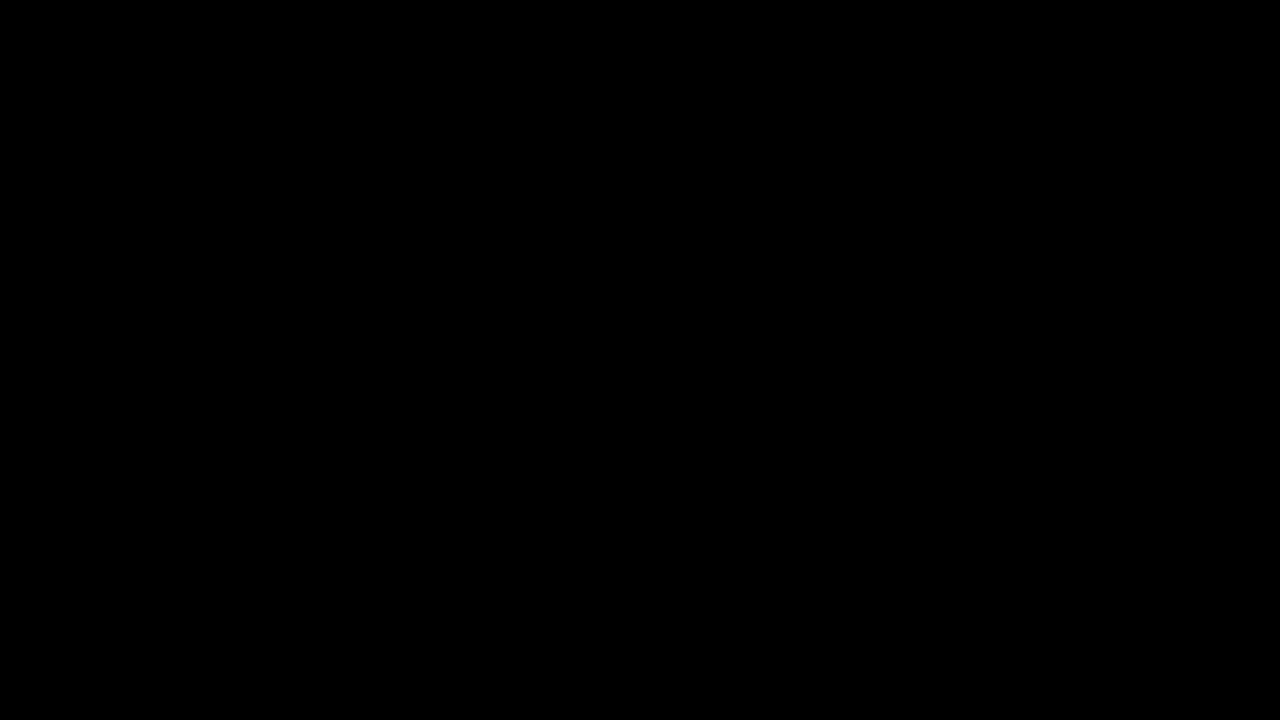
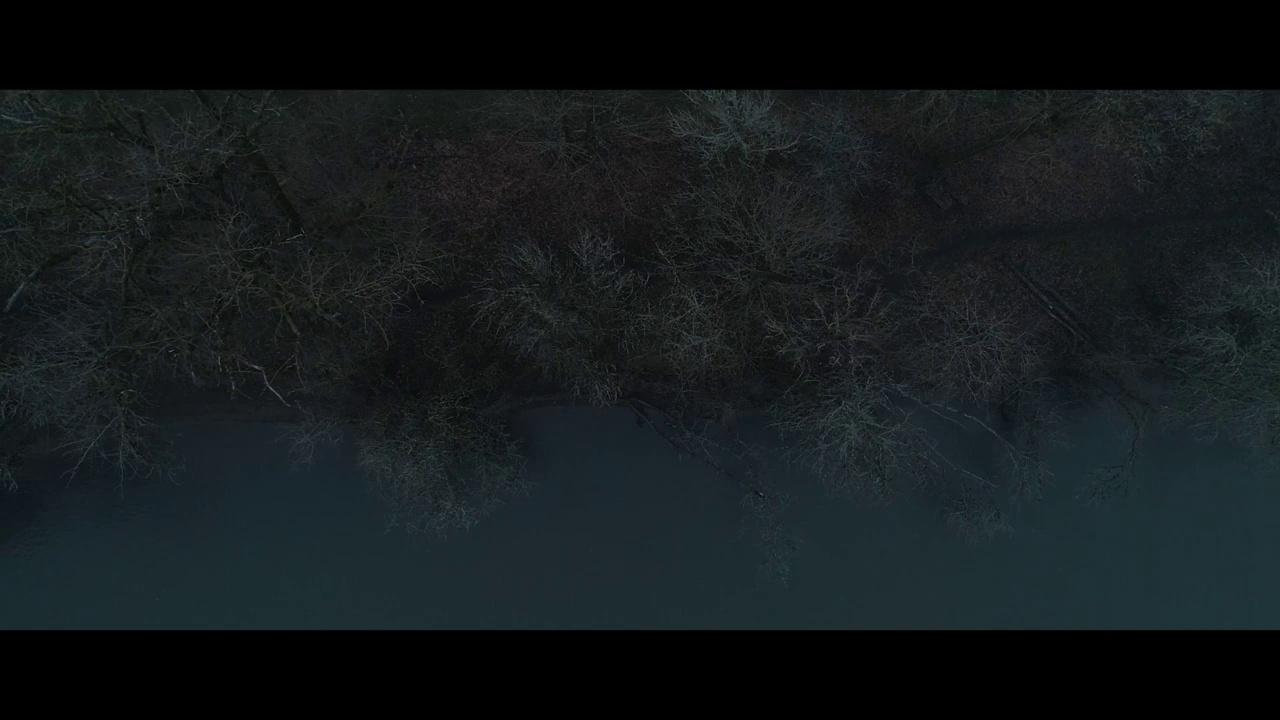
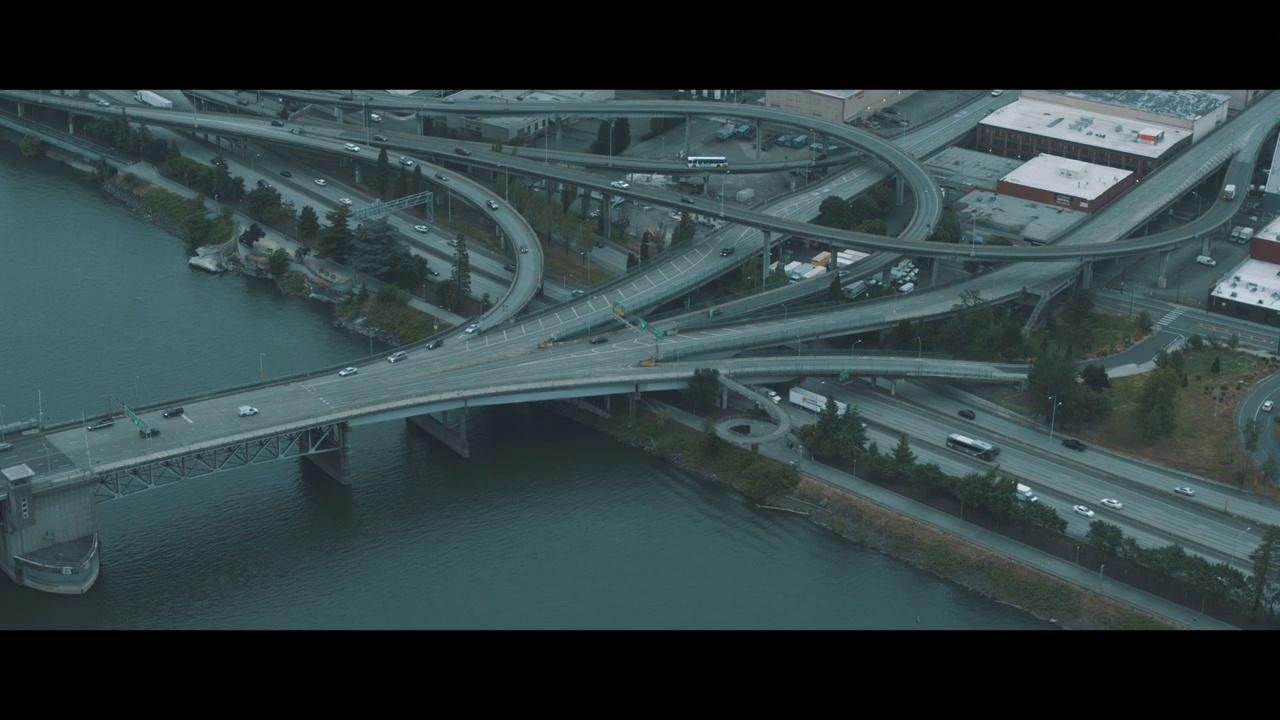
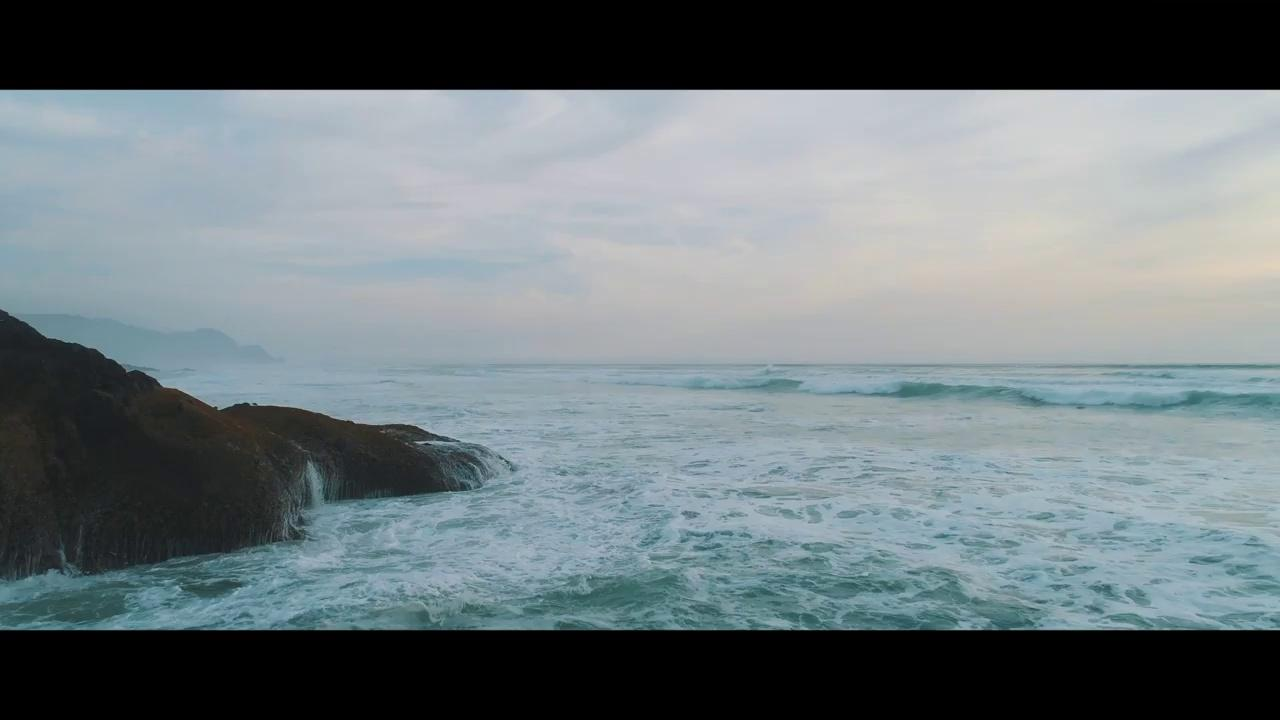
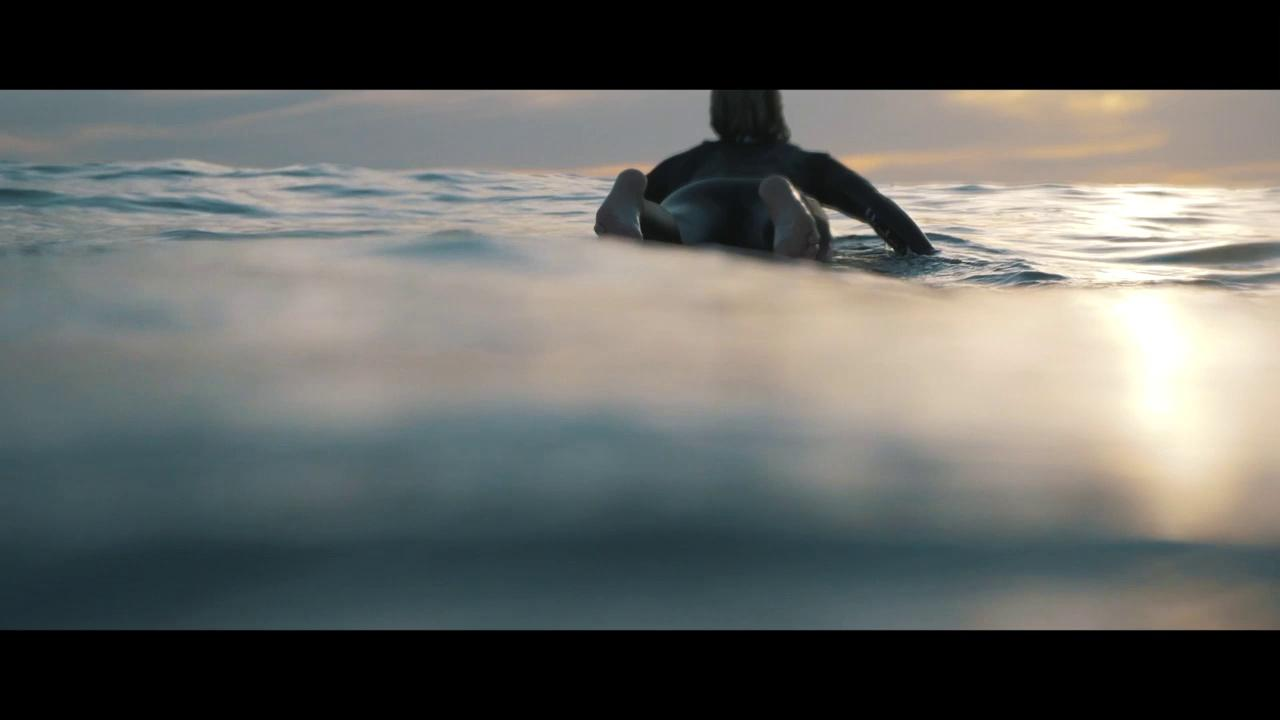
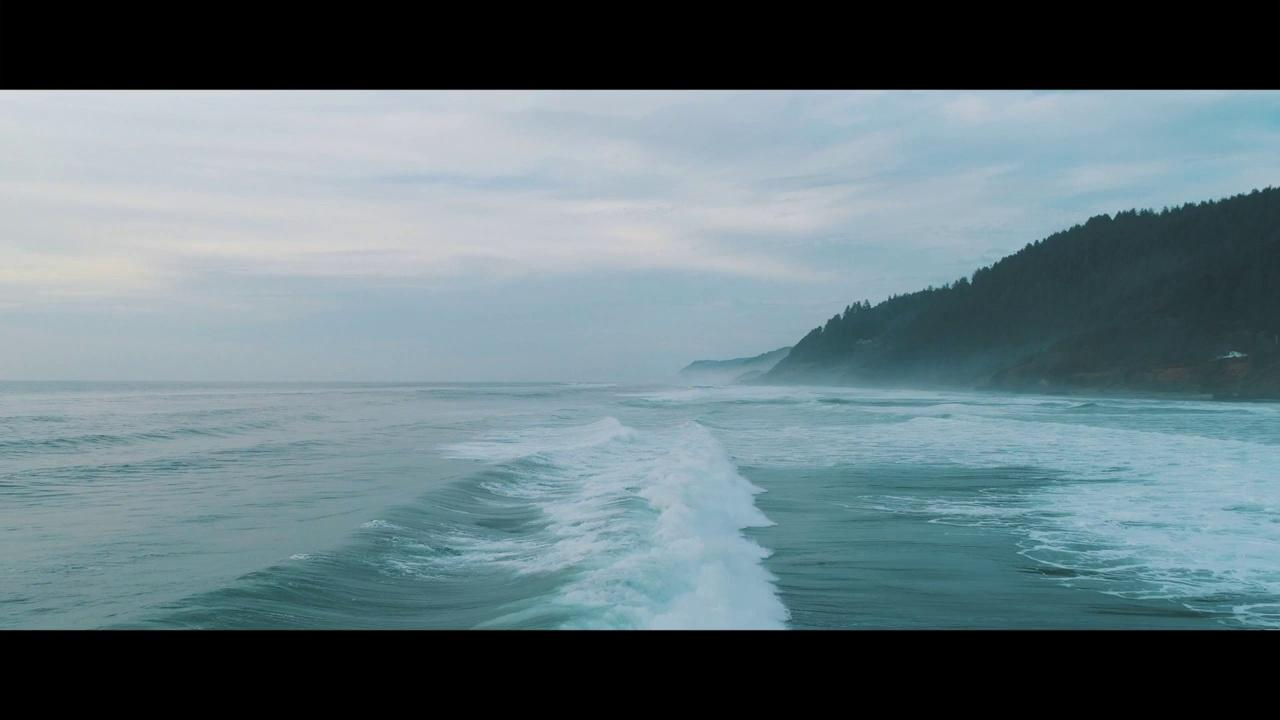
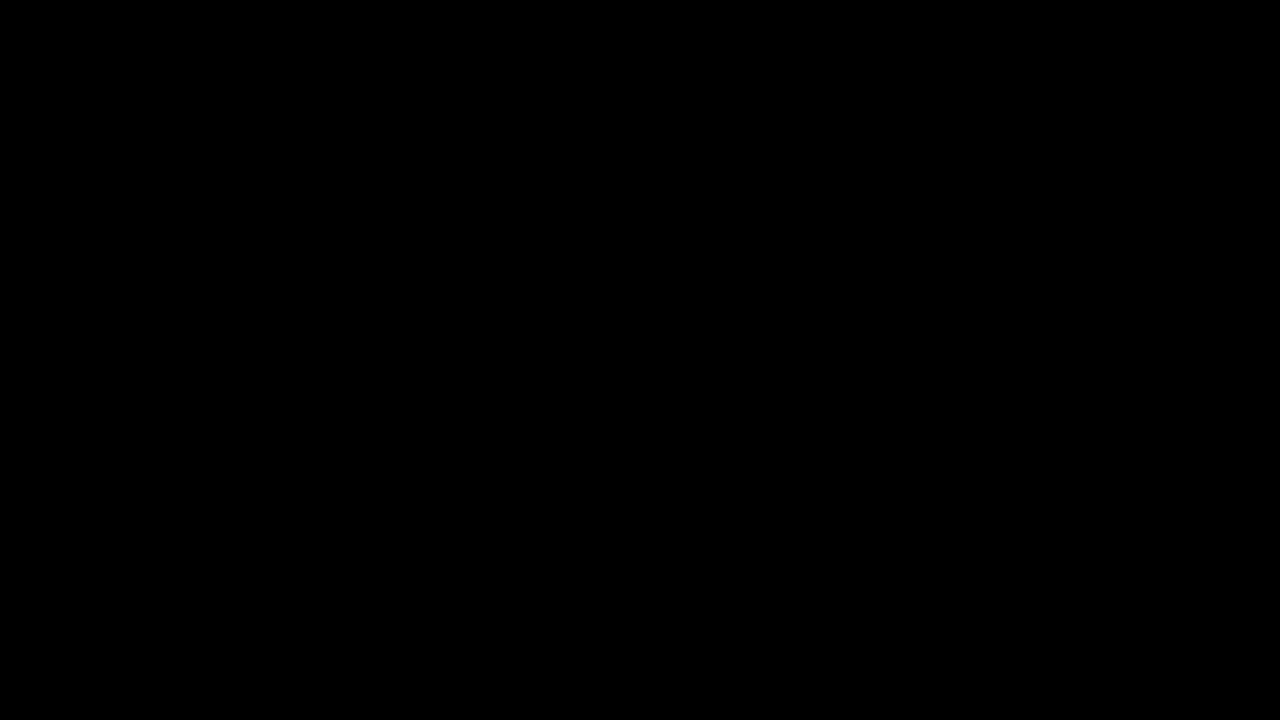
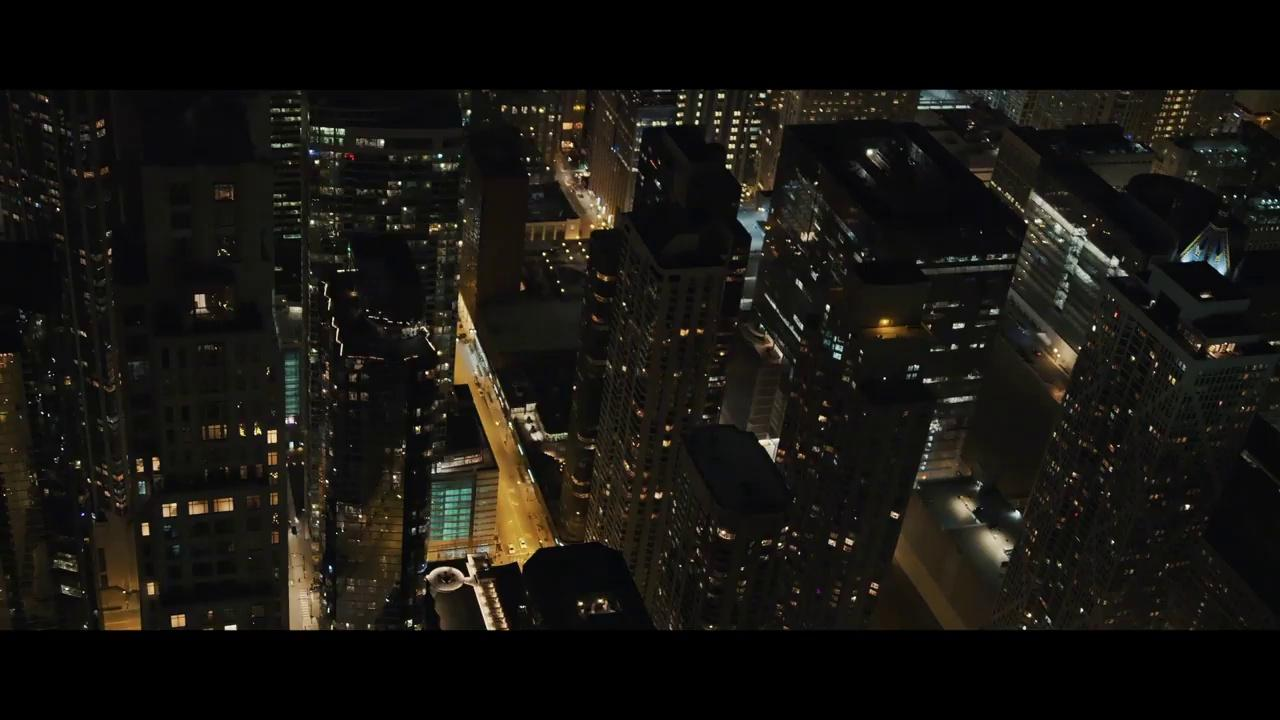

In [20]:
p1.table.show()

In [21]:
p1.add_scene_description("with_prompt_2", prompt="Describe in 10 words")

Computing cells: 100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 691.93 cells/s]
Added 8 column values with 0 errors.


start,end,frame_1,with_prompt_2
0.,10.01,,Tree against a beautiful mountain and sky in the evening.
10.01,20.02,,"Dark, overhead view, dense trees, murky water, eerie, mysterious, hauntingly beautiful."
20.02,30.03,,Complex highway interchange with multiple overpasses over a river.
30.03,40.04,,"Waves crashing against rocks on a peaceful, cloudy seaside horizon."
40.04,50.05,,Person on a surfboard paddling in the ocean at sunset.
50.05,60.06,,"Calm ocean waves, foggy coastal hills, serene and peaceful sky."
60.06,70.07,,"Young woman silhouette, long hair, arms raised, dancing, celebratory pose."
70.07,78.996,,City skyline at night with illuminated buildings and lit streets.

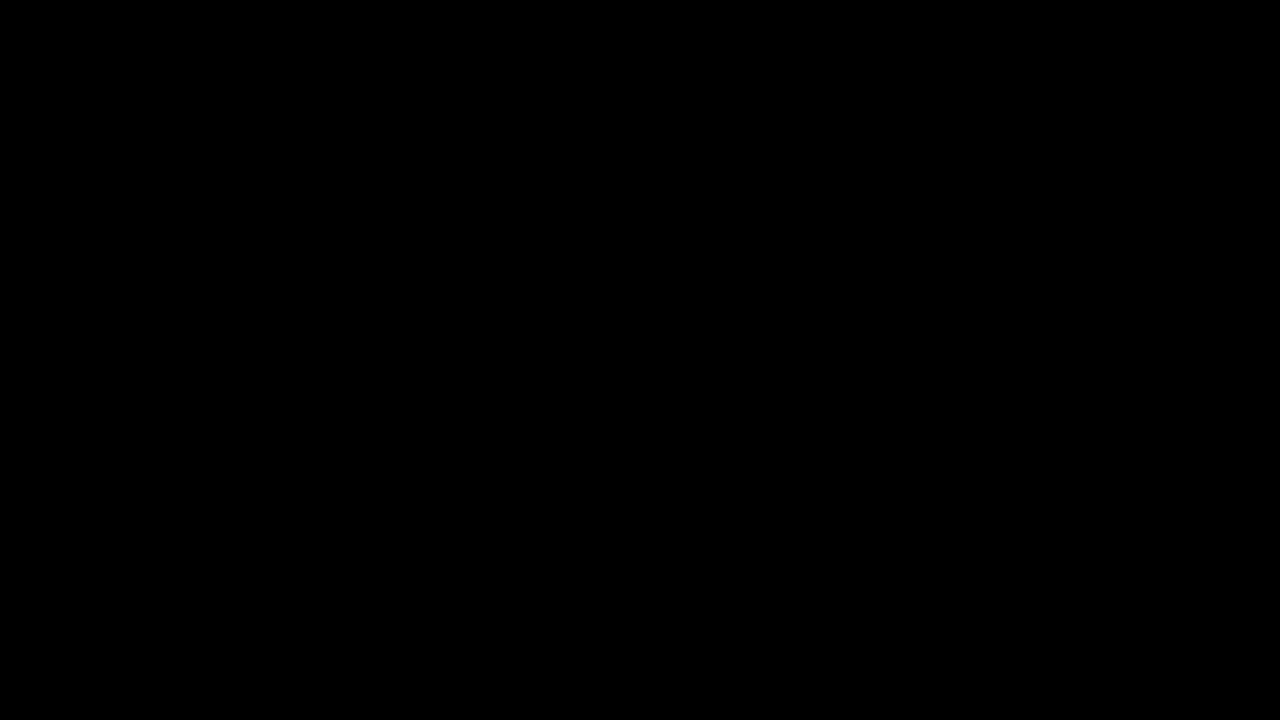
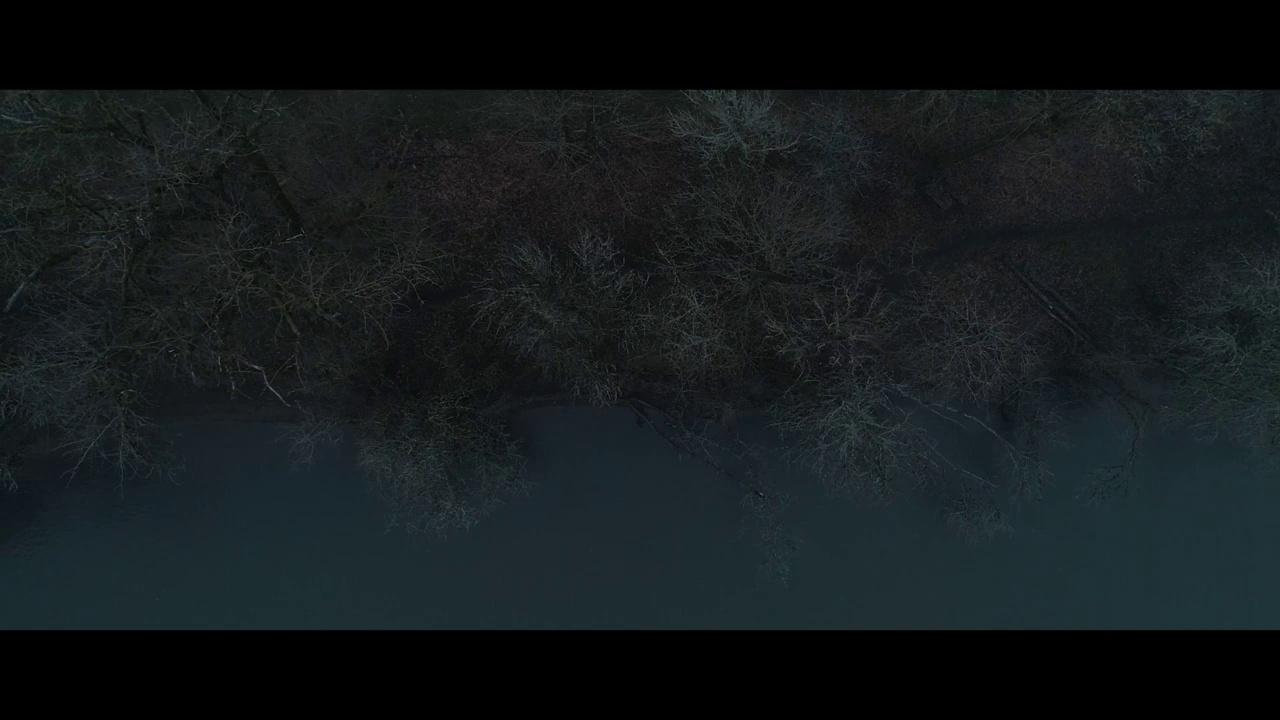
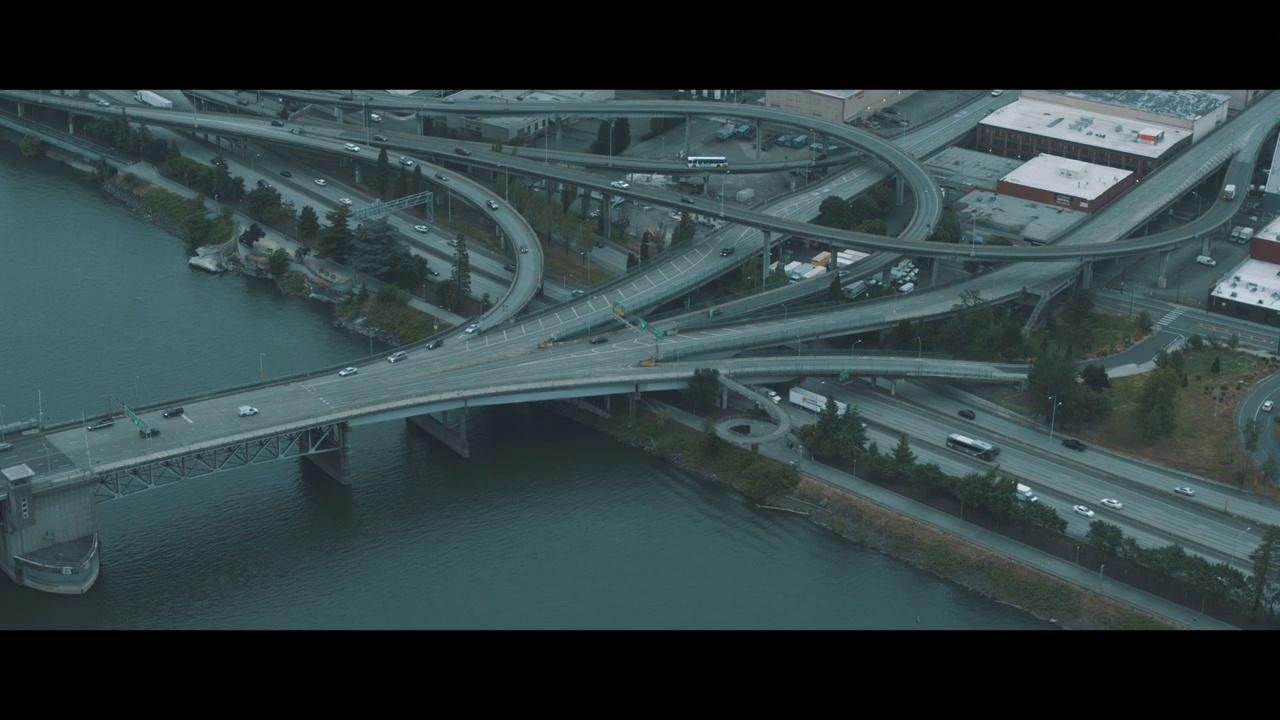
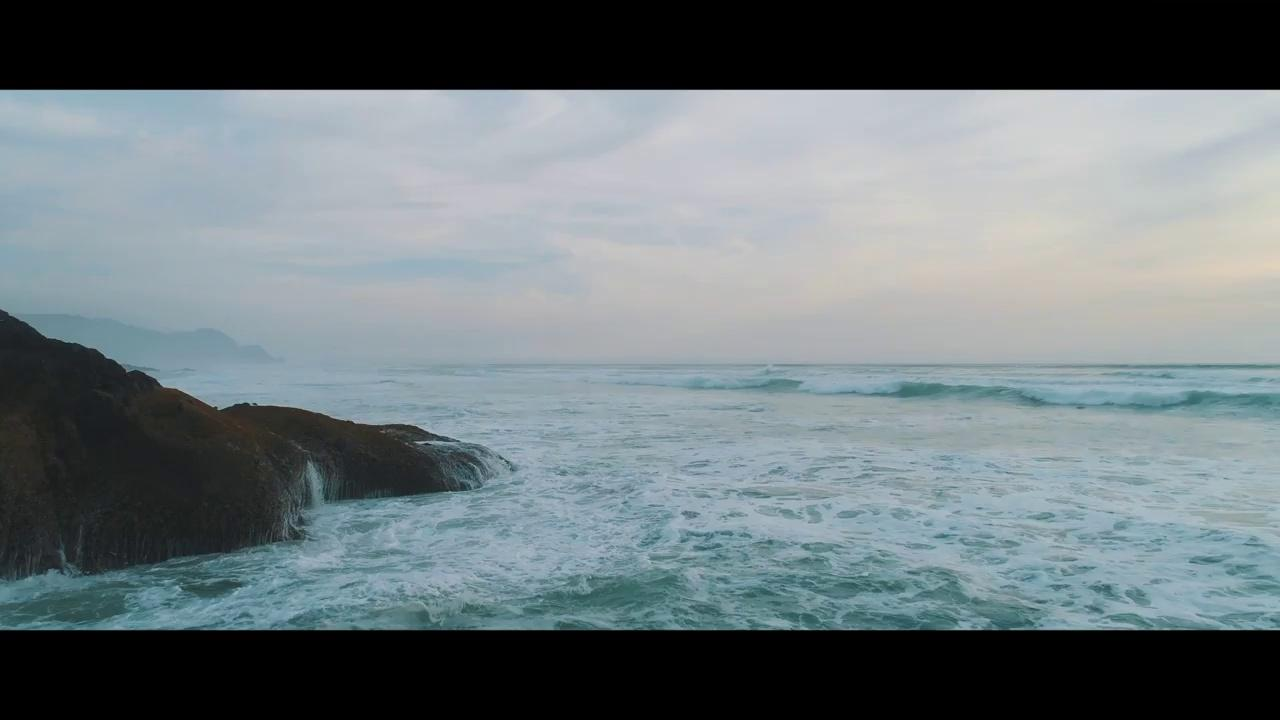
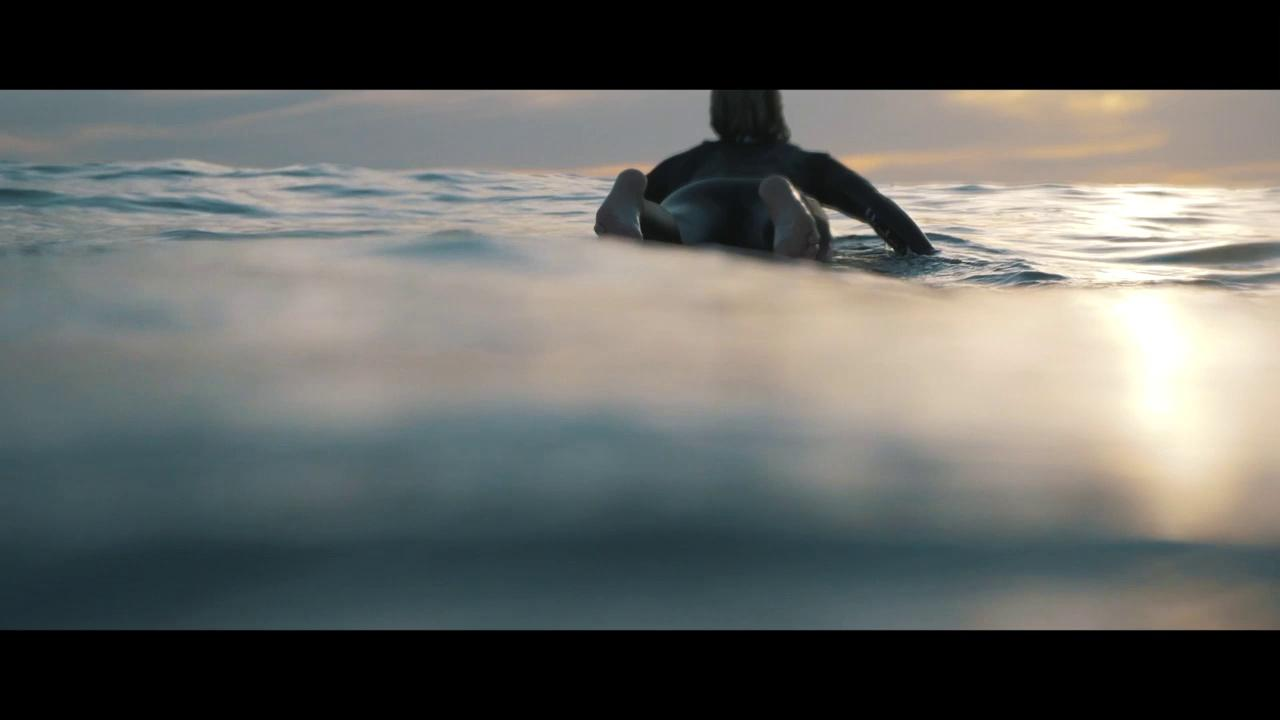
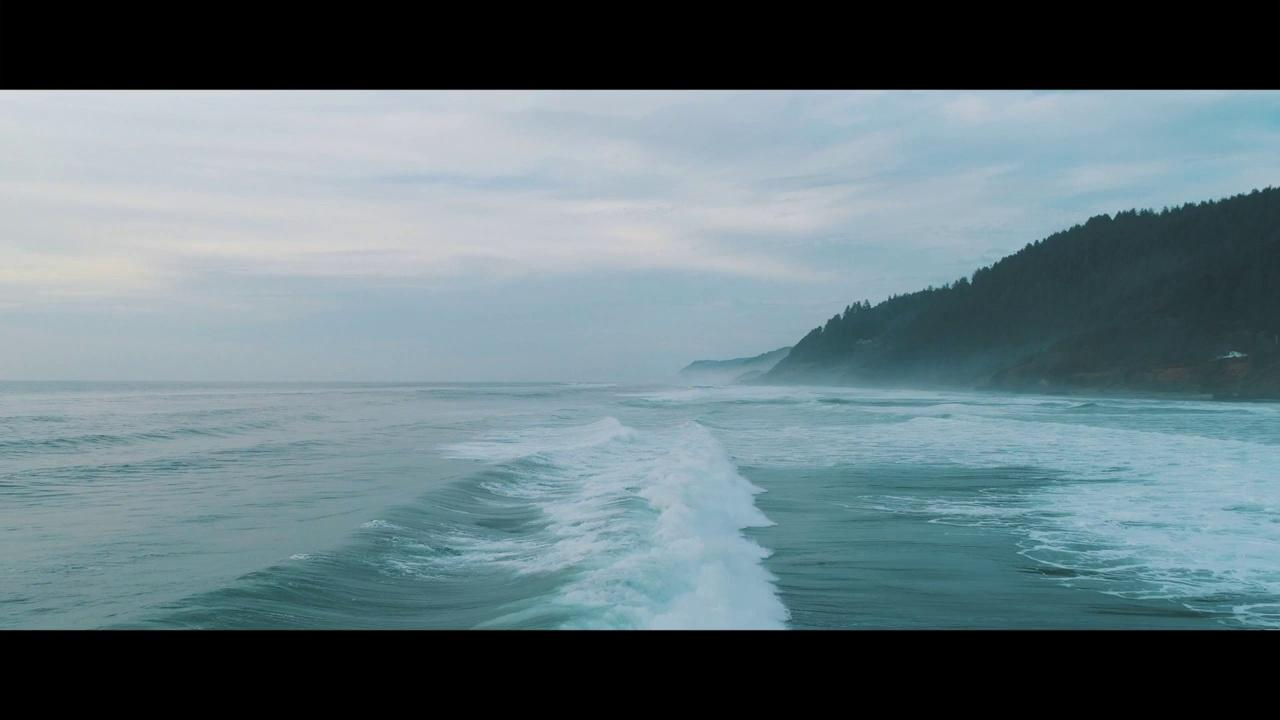
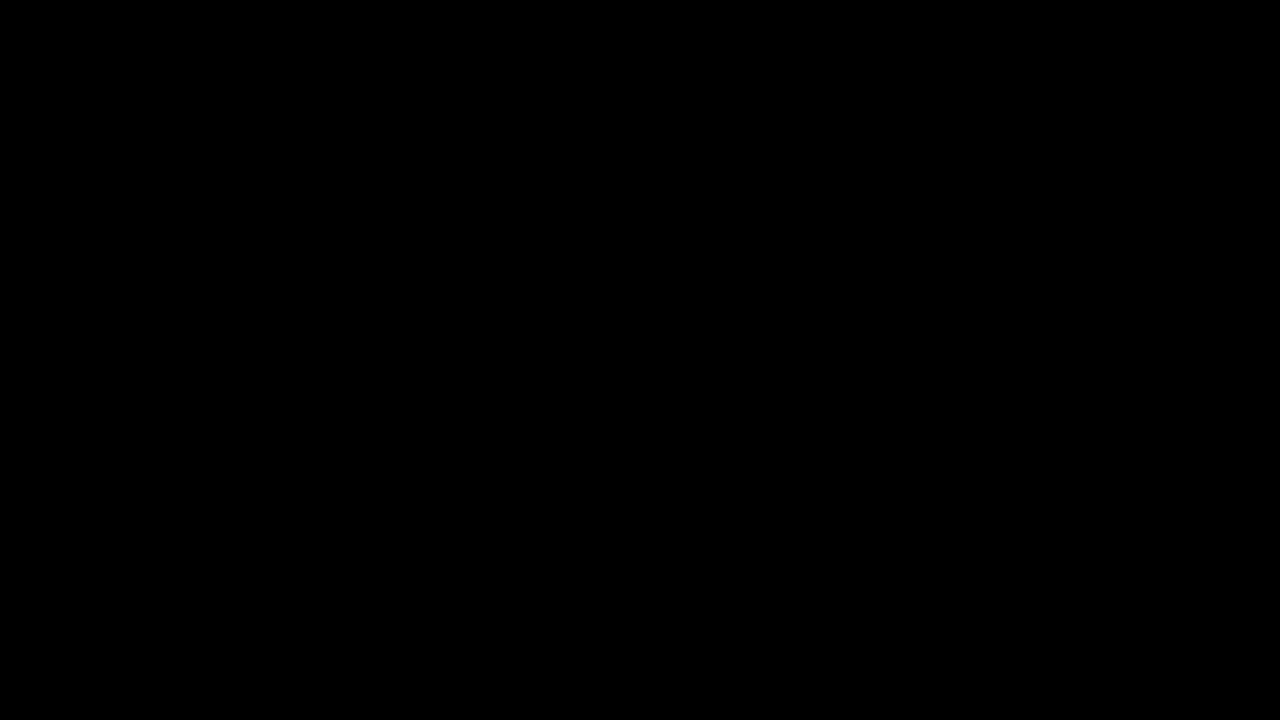
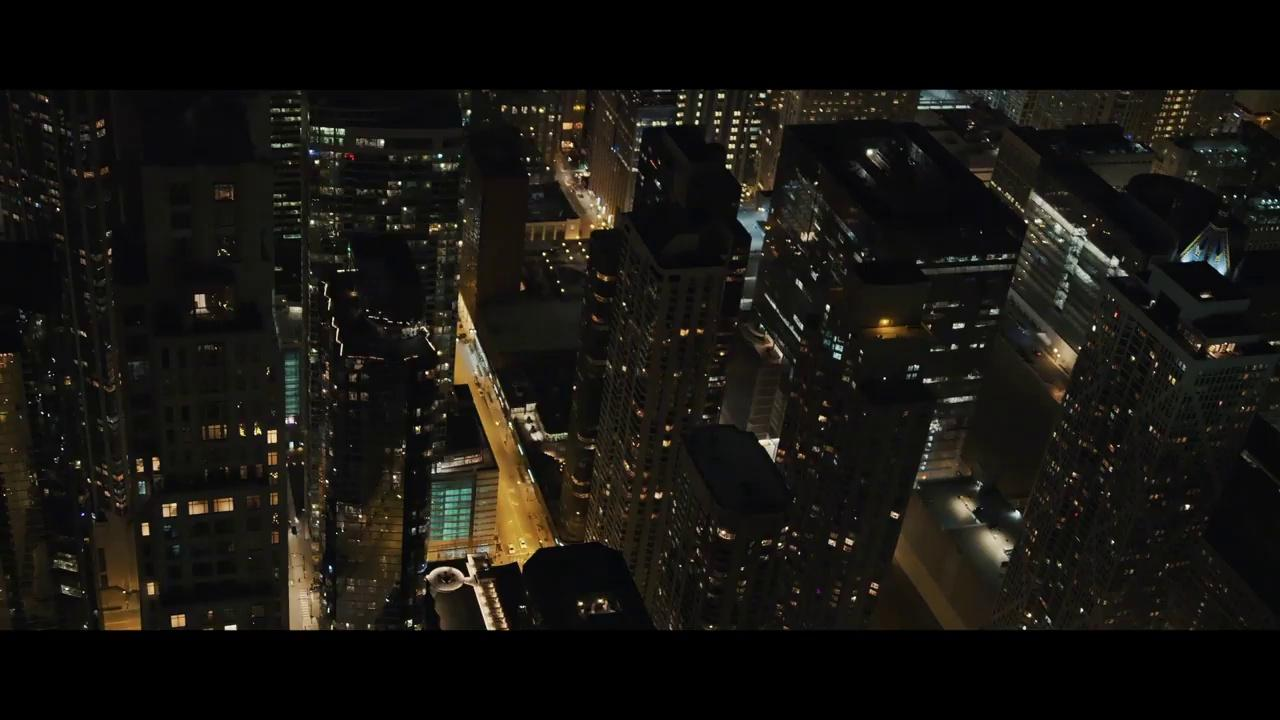

In [22]:
p1.table.order_by(p1.table.start).show()

In [24]:
p1.add_stream_preview("preview", description_col=p1.table.with_prompt_2)

Computing cells: 100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 564.65 cells/s]
Added 8 column values with 0 errors.


frame_1,with_prompt,with_prompt_2
,Needle with red thread.,None
,"Misty, forest, aerial, mysterious.","Aerial view, dark forest, bare trees, overhang, calm water, twilight."
,Complex highway over water.,"Complex highway interchanges over river, multiple elevated roadways and ramps."
,"Calm ocean, foggy horizon.",Ocean waves crash against rocks under an overcast sky. Serene.
,Surfer paddling at sunset.,"Surfer paddling in ocean during sunset, calm and peaceful moment."
,"Misty, coastal, serene, expansive","Calm ocean waves meet misty mountains under soft, gray-blue sky."
,Blue home icon symbol,"Man walking down road, trees lining, mountains in distance, suitcase."
,"Night cityscape, tall buildings.","City skyline at night, illuminated buildings, bustling streets below."

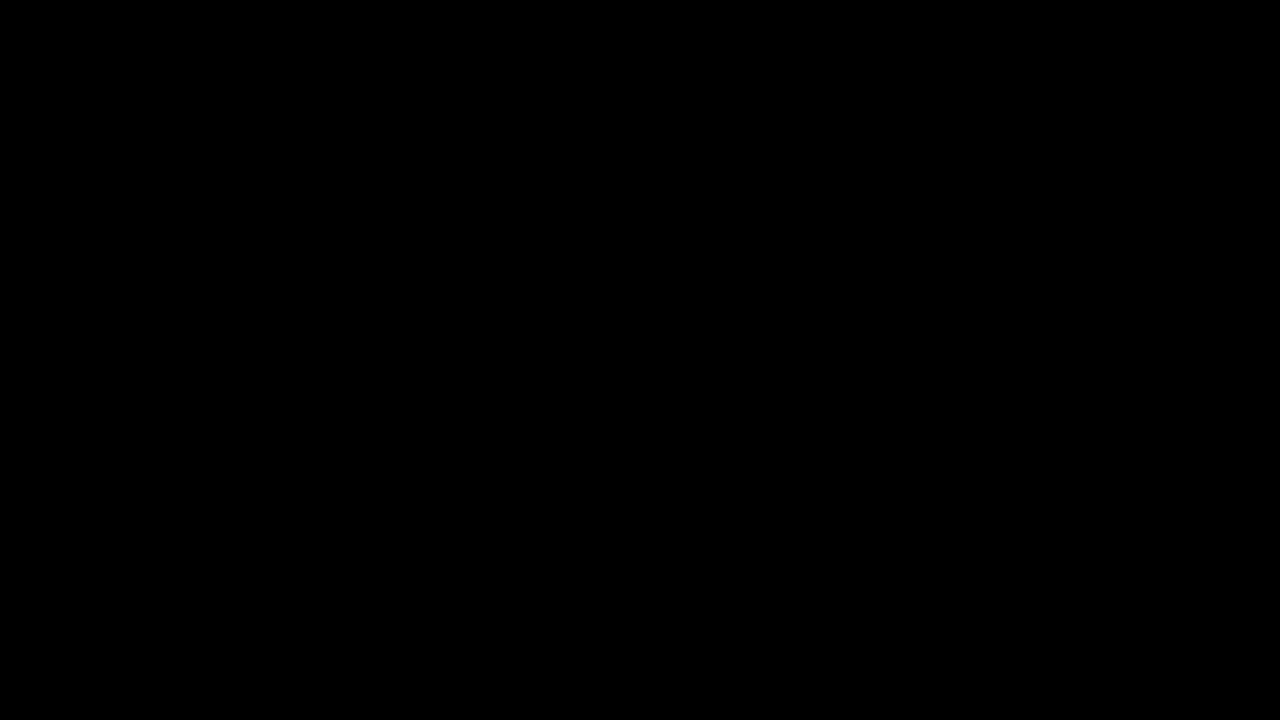
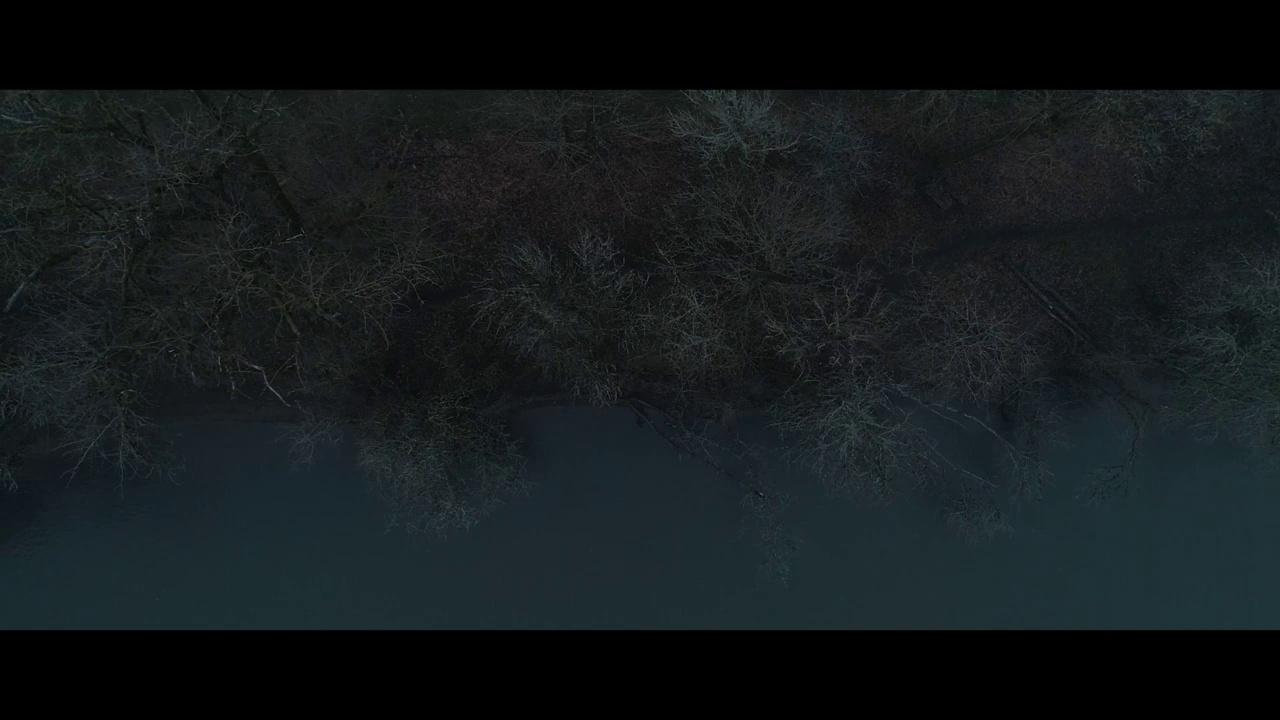
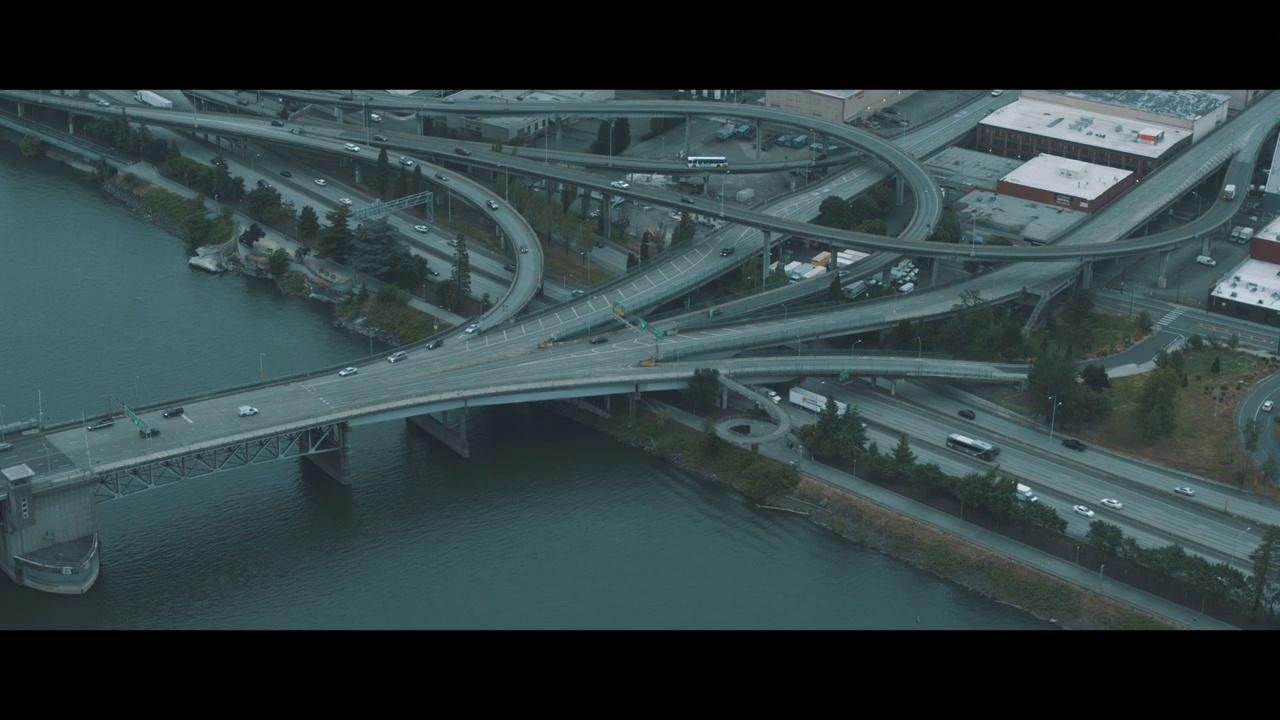
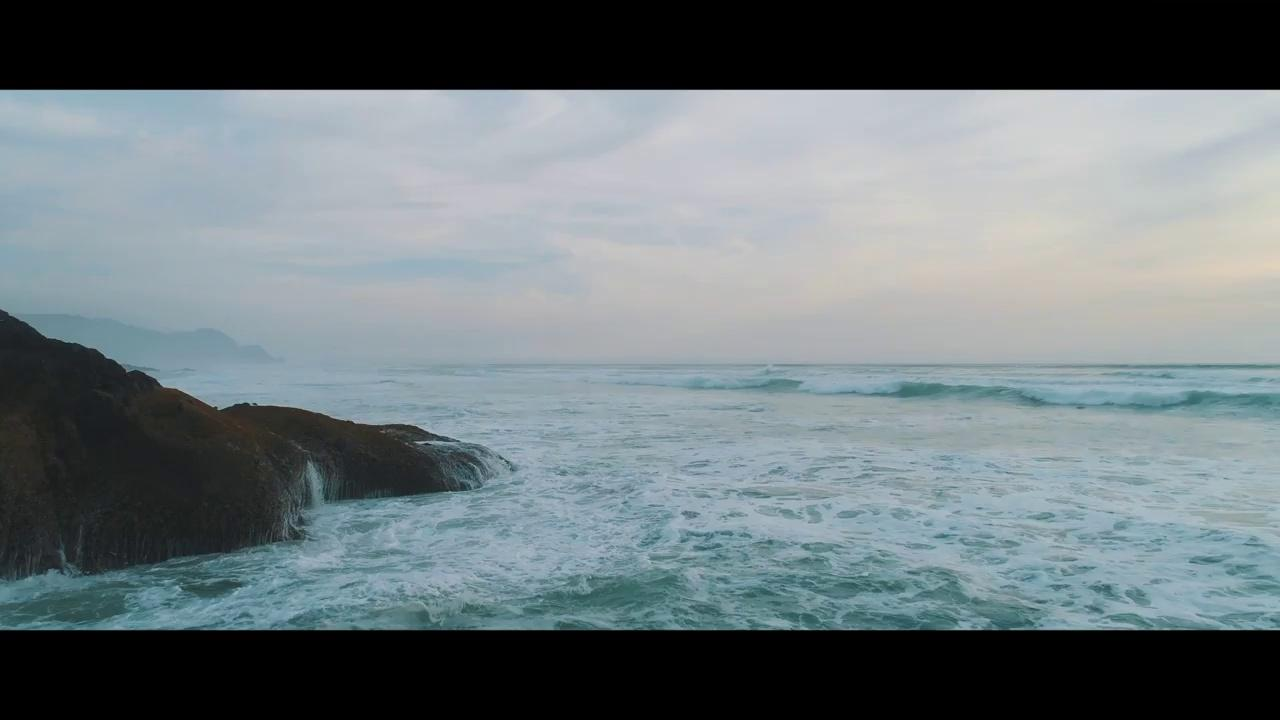
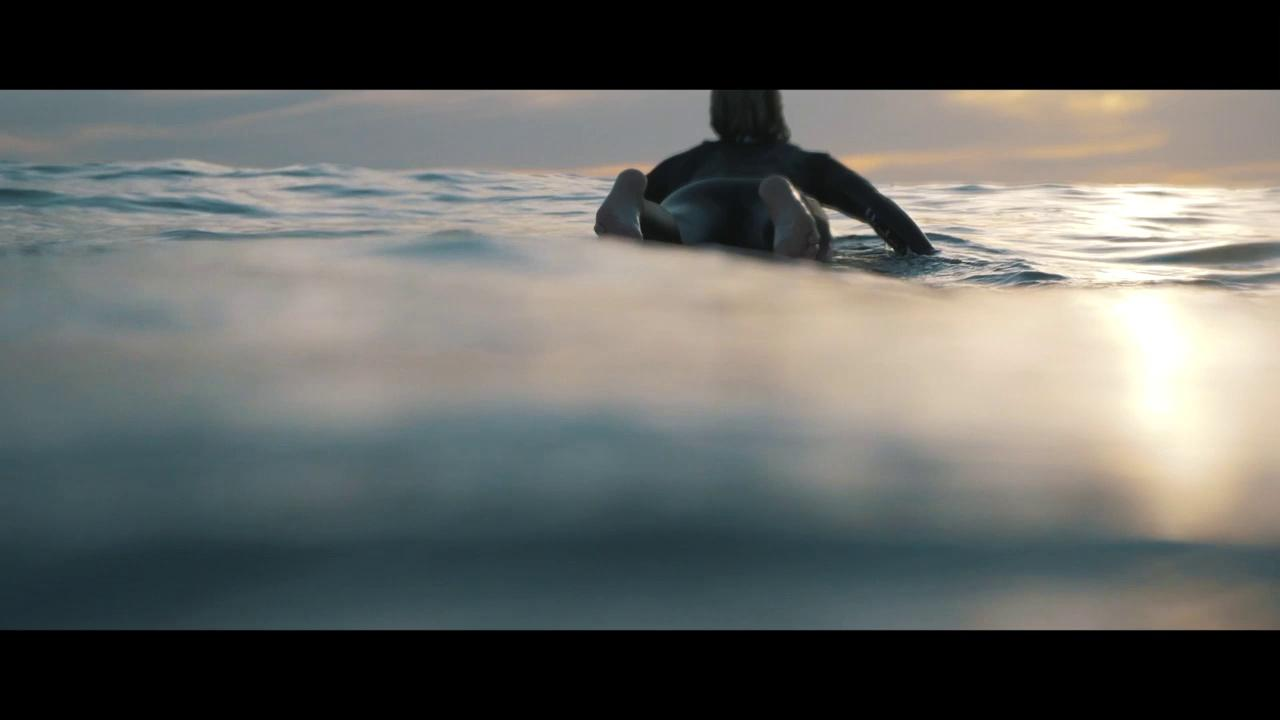
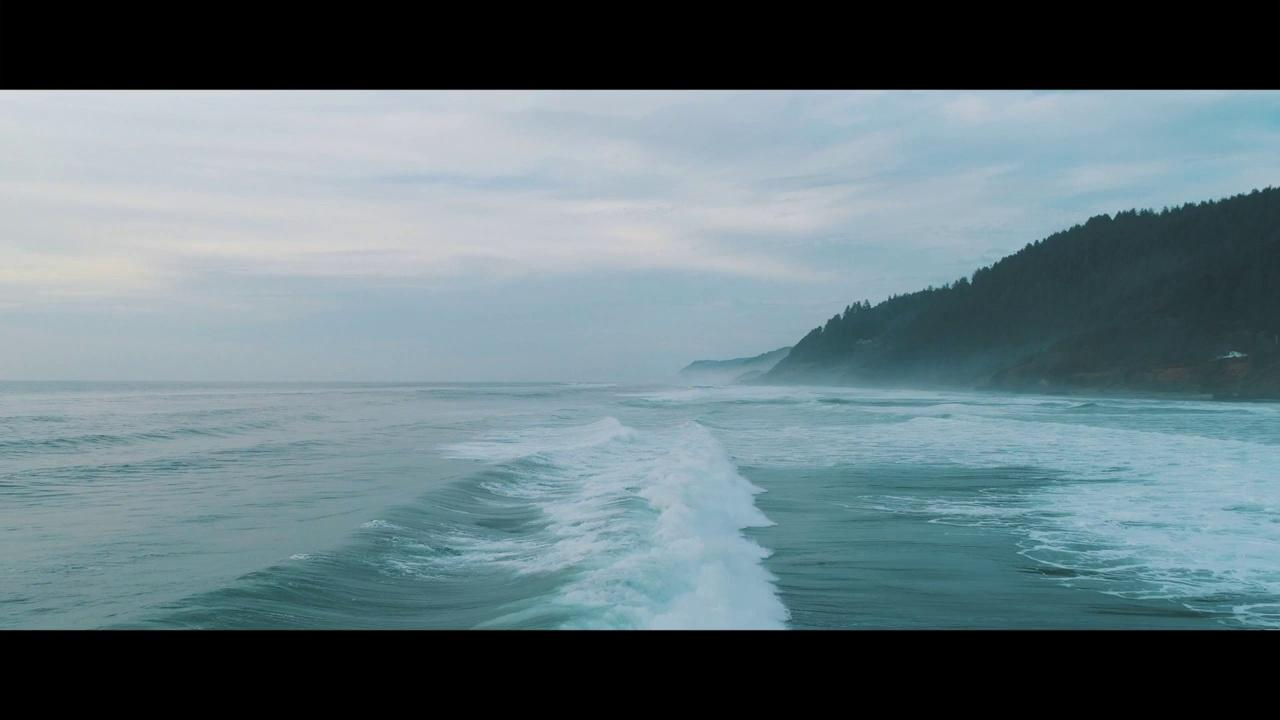
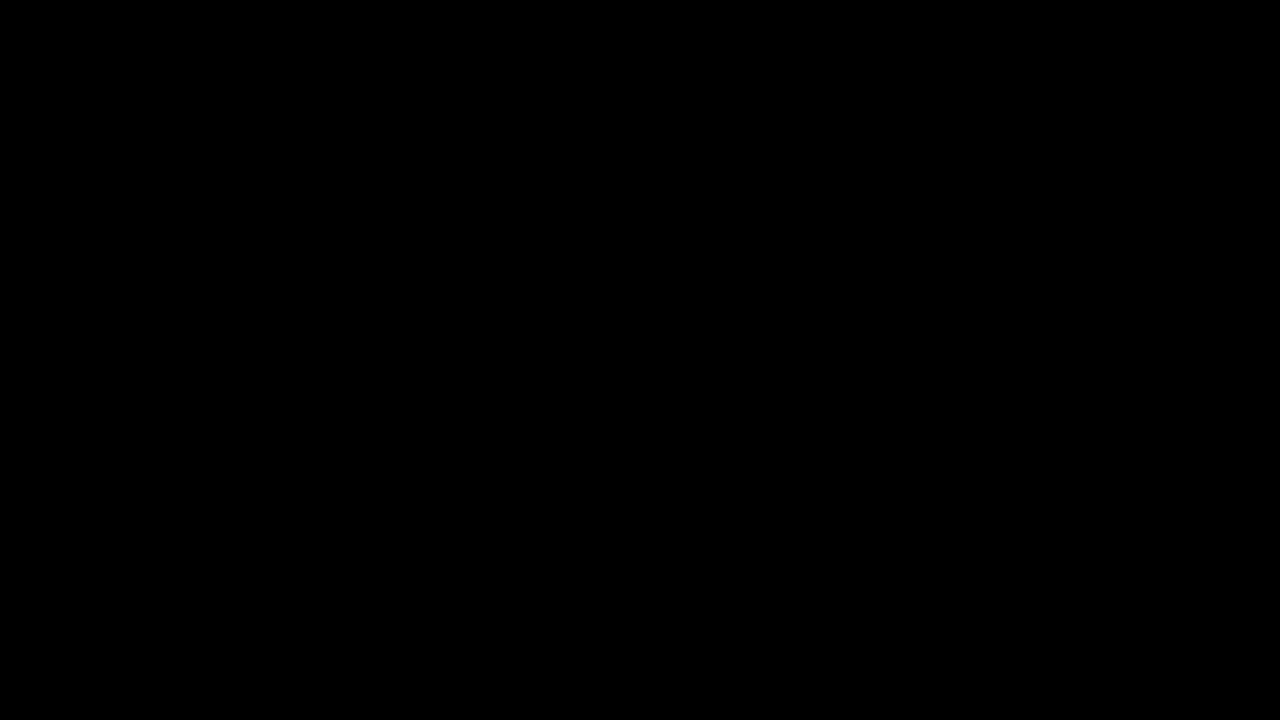
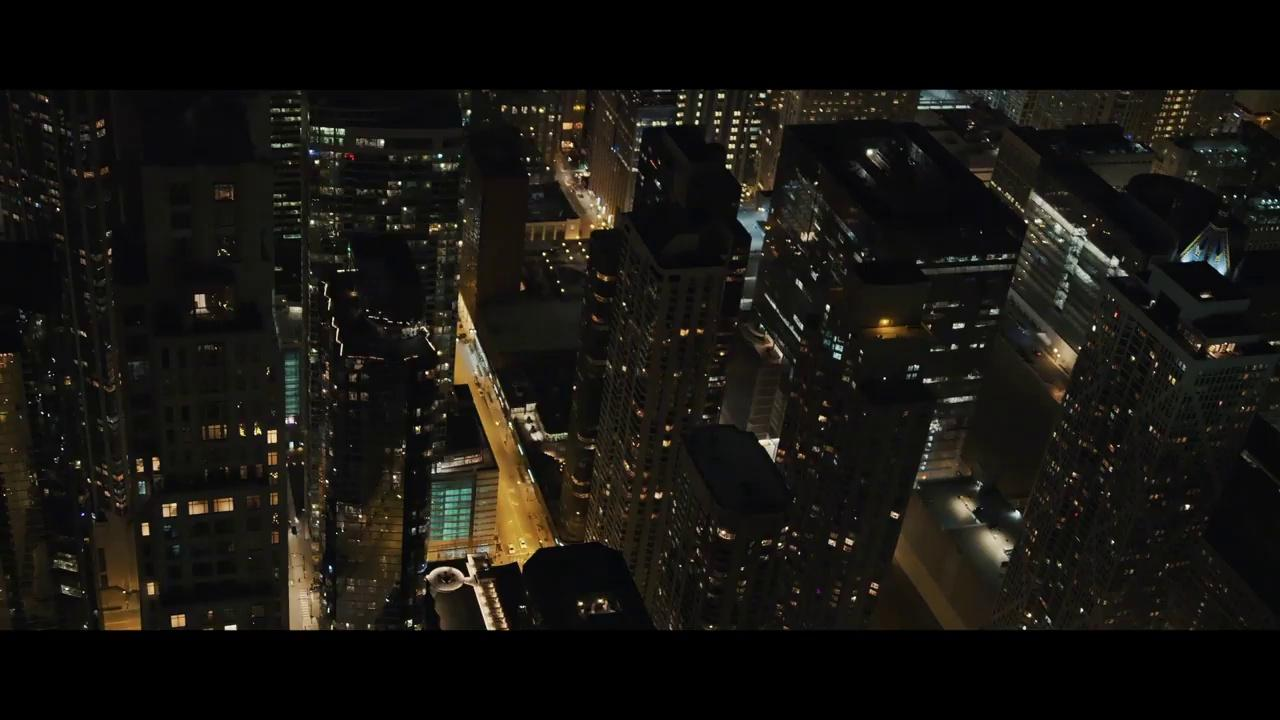

In [32]:
p1.table.select(p1.table.frame_1, p1.table.with_prompt, p1.table.with_prompt_2).order_by(p1.table.start).show()